[*********************100%***********************]  1 of 1 completed



Strategy Signal Counts:
Strategy
 1.0    60
-1.0    39
Name: count, dtype: int64


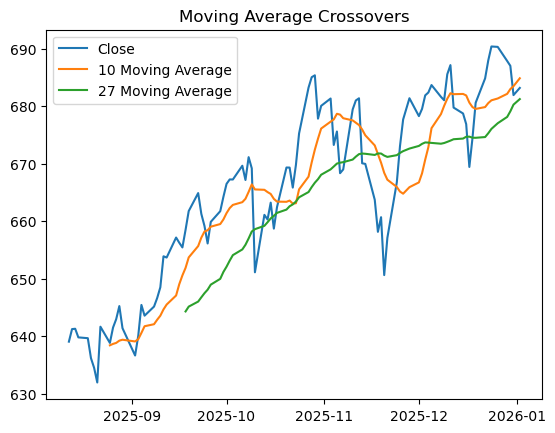

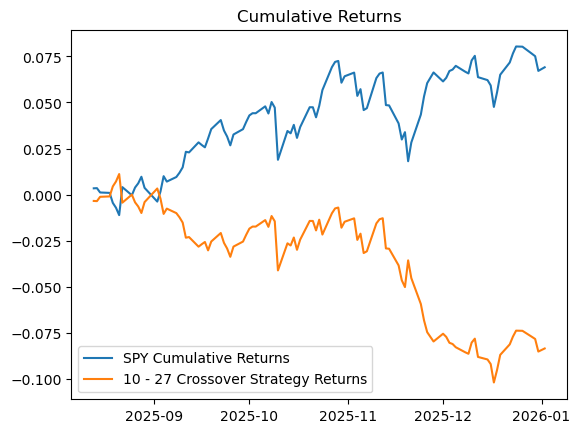

In [4]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd # Iloc Function
import numpy as np
import yfinance_fix

TICKER = "SPY"
FAST = 10 # WINDOW = 10 Days in retrospect
SLOW = 27 # WINDOW = 27 Days in retrospect
LOOKBACK = 100 # Global subsection - Nr. of days/rows in retrospect

# Bring all of the Code together in Functions
def get_data():
    df = yf.download("SPY", start="1993-01-01", session=yfinance_fix.chrome_session)
    df.columns = df.columns.get_level_values(0)
    return df.iloc[-LOOKBACK:, :]

def add_moving_averages(df, fast, slow):
    # f"" - F-String, so that the global variables can be updated accordingly 
    # Defining the Moving Averages to access a Crossover Strategy
    df[f"{FAST}_ma"] = df["Close"].rolling(fast).mean()
    df[f"{SLOW}_ma"] = df["Close"].rolling(slow).mean()
    return df

# Adding Strategy Signal - Define where we want to change our bahavior
def add_strategy(df, fast, slow):
    # Long (1) when fast MA > slow MA; 
    # Short (-1) when fast MA < slow MA 
    df["Strategy"] = np.where(df[f"{fast}_ma"] > df[f"{slow}_ma"], 1, -1)
    # Shift the signal to prevent lookahead bias - you can only act on the signal, once the day is over:
    df["Strategy"] = df["Strategy"].shift(1)
    return df

# Use Numpy to Calculate Cumulative Returns
def test_strategy(df, ticker, fast, slow):
    df["asset_cum_returns"] = (1 + df["Close"].pct_change()).cumprod() - 1
    df["strategy_cum_returns"] = (1 + df["Close"].pct_change() * df["Strategy"]).cumprod() - 1
    return df

# Ticker in lower case, since it is an argument instead of a global variable
def plot_results(df, ticker, fast, slow, lookback):

    # Plotting Moving Averages
    plt.figure()
    plt.plot(df["Close"]) 
    plt.plot(df[f"{fast}_ma"])
    plt.plot(df[f"{slow}_ma"])
    plt.legend(["Close", f"{fast} Moving Average", f"{slow} Moving Average"]) 
    plt.title("Moving Average Crossovers")

    # Plotting Cumulative Crossover Returns 
    plt.figure()
    plt.plot(df["asset_cum_returns"]) #plt.plot(subset["asset_cum_returns"])
    plt.plot(df["strategy_cum_returns"]) # plt.plot(subset["strategy_cum_returns"])
    plt.legend([f"{ticker} Cumulative Returns", f"{fast} - {slow} Crossover Strategy Returns"]) 
    plt.title("Cumulative Returns")
    return

def main():
    df = get_data()
    df = add_moving_averages(df, FAST, SLOW)
    df = add_strategy(df, FAST, SLOW)
    df = test_strategy(df, TICKER, FAST, SLOW)
    plot_results(df, TICKER, FAST, SLOW, LOOKBACK)

    # Counting nr of times: Long (Strategy = 1), Short (Strategy = -1)
    strategy_counts = df["Strategy"].value_counts()
    print("\nStrategy Signal Counts:")
    print(strategy_counts)

    return df

# print(df)

# It's good practice to run your main function like this:
if __name__ == "__main__":
    final_df = main()